## Sentiment Analysis with LSTM

The IMDb dataset is a large collection of movie reviews compiled by the Internet Movie Database (IMDb), one of the most comprehensive online databases for films, TV shows, actors, and production crew information. IMDb is widely used for accessing details such as cast lists, user ratings, reviews, and plot summaries [(source)](https://www.geeksforgeeks.org/data-science/imdb-datasets-types-usages-and-application/).

In this mini-project, you will perform **sentiment analysis** on IMDb movie reviews using **LSTM-based models**. The goal is to classify each review as positive or negative.

You are required to build and train:

* A **simple LSTM model**, aiming for at least **75% test accuracy**
* A **more advanced LSTM model**, trying to push the accuracy as high as possible
* A **function** that can evaluate the sentiment of any new review

In [1]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
import re
import os


torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Setup complete. Using device: {device}")

Setup complete. Using device: cuda


### Task 1 (0 pts)

To load the data, we will use [Hugging Face](https://huggingface.co/), an open-source platform that provides datasets, pre-trained models, and tools for modern machine learning.
**Note:** In principle, you could also use [TorchText](https://docs.pytorch.org/text/main/datasets.html#imdb), but it does not work reliably on Kaggle. Using PyTorch’s dataset instead of Hugging Face is **not** considered an error.

Inspect the dataset you load and make sure you understand its structure and format.

In [2]:
ds = load_dataset("stanfordnlp/imdb")

print("Dataset Structure:")
print(ds)


dataset_train = ds['train']
dataset_test = ds['test']

print("\nFeatures")
print(dataset_train.features)

print("\nSample Entry (Train [0])")
sample_review = dataset_train[0]
print(f"Text snippet: {sample_review['text'][:200]}...") # Print first 200 chars
print(f"Label: {sample_review['label']}") 

# Check the label meaning ( 0: Negative, 1: Positive)
# In the IMDb dataset: 0 = Negative, 1 = Positive
print(f"Label Type: {type(sample_review['label'])}")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Features
{'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

Sample Entry (Train [0])
Text snippet: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...
Label: 0
Label Type: <class 'int'>


### Task 2 (5 pts)

Split the original **test set** into two parts: a **validation set** and a **final test set**. Use a split of 50-50.

**Note:** We are aware that, in a typical machine learning workflow, you would split the **training set** (not the test set) to create a validation set. However, in this exercise, we intentionally use the test set for this purpose to provide you with **more training data** for model learning.

In [3]:
# Split the dataset_test into two equal parts (50% each)
# We use seed=123 to ensure the split is reproducible (same every time you run it)
test_split = dataset_test.train_test_split(test_size=0.5, seed=123)

# The result is a DatasetDict with keys 'train' and 'test'. 
# We assign them to our new variable names:
dataset_valid = test_split['train']
dataset_test_final = test_split['test']

# Verify the sizes to ensure the split worked as expected
print(f"Original Training Set Size:   {len(dataset_train)}")
print(f"New Validation Set Size:      {len(dataset_valid)}")
print(f"New Final Test Set Size:      {len(dataset_test_final)}")

Original Training Set Size:   25000
New Validation Set Size:      12500
New Final Test Set Size:      12500


### Task 3 (10 pts)

Create a `tokenize` function that takes a line from your dataset (a review) and converts it into tokens.
You may want to consider the following:

* Are `film` and `film.` considered different?
* Does it matter if a word is uppercase or lowercase?
* Should tokens like `<br />` be included or removed?

In [4]:
def tokenize(line):
    """
    Converts a string into a list of tokens (words).
    """
    
    line = line.lower()
    
    line = line.replace('<br />', ' ')
    
    line = re.sub(r'[^\w\s]', ' ', line)
    
    tokens = line.split()
    
    return tokens

test_sentence = "I loved this film! It was great.<br />However, the ENDING was bad."
print(tokenize(test_sentence))

['i', 'loved', 'this', 'film', 'it', 'was', 'great', 'however', 'the', 'ending', 'was', 'bad']


### Task 4 (5 pts)
Create two dictionaries, `word_to_idx` and `idx_to_word`, to map words to their embedding indices and vice versa. At this stage, you should decide whether to remove outlier words and replace them with the `<UNK>` token. This decision will, of course, depend on the performance you observe afterward.

In [5]:
word_to_idx = {'<PAD>': 0, '<UNK>': 1}
idx_to_word = {0: '<PAD>', 1: '<UNK>'}

all_tokens = []
print("Building the vocabulary...")

for text in dataset_train['text']:
    #use the function tokenize in the task 3 
    tokens = tokenize(text)
    all_tokens.extend(tokens)

word_counts = Counter(all_tokens)

# filtering rare words 
min_frequency = 2  # if a word appear less then two times it will be discarted 
curr_idx = 2       

for word, count in word_counts.items():
    if count >= min_frequency:
        word_to_idx[word] = curr_idx
        idx_to_word[curr_idx] = word
        curr_idx += 1

print(f"Vocabulary Completed. Total dimension: {len(word_to_idx)} token.")
print(f"Word at index 2: {idx_to_word[2]}") # example

Building the vocabulary...
Vocabulary Completed. Total dimension: 47009 token.
Word at index 2: i


### Task 5 (10 pts)
Create a `Dataset` class. The `__getitem__` function should return `(X, y)`, where `X` is a tensor containing the indices of the embedded words, and `y` is a tensor representing the sentiment expressed in the review.


In [6]:
#Optimized Dataset 
class DatasetIMDB(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Pre-processing function 
def preprocess_dataset(dataset, word_to_idx):
    print(f"Optimization {len(dataset)} example in RAM...", end="")
    X_list = []
    y_list = []
    unk_idx = word_to_idx['<UNK>']
    
    for item in dataset:
        tokens = tokenize(item['text'])
        indices = [word_to_idx.get(t, unk_idx) for t in tokens]
        X_list.append(torch.tensor(indices, dtype=torch.long))
        y_list.append(torch.tensor(item['label'], dtype=torch.float32))
        
    print(" Done!")
    return X_list, y_list

### Task 6 (10 pts)

Define a `collate` function for your DataLoader that ensures all sequences in a batch have the same length. The function should pad shorter sequences with the `<PAD>` index, so that every sequence in the batch matches the length of the longest sequence.

In [7]:
def collate_fn(batch):
    #1. Separation of input (X) from targets (y)
    inputs, labels = zip(*batch)

    # 2. Padding of sequences
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)

    # 3. Stack of targets
    labels_tensor = torch.stack(labels)

    return padded_inputs, labels_tensor

### Task 7 (5 pts)

Create one `DataLoader` for each dataset: Training, Validation, and Test. Make sure each `DataLoader` uses your `Dataset` class and the `collate_fn` function you defined in Task 6.

In [8]:

# 1. PRE-PROCESSING (Text to Tensor conversion)
print("Starting data preparation (Tokenization and indexing)...")

train_X, train_y = preprocess_dataset(dataset_train, word_to_idx)
valid_X, valid_y = preprocess_dataset(dataset_valid, word_to_idx)
test_X, test_y = preprocess_dataset(dataset_test_final, word_to_idx)

# 2. DATASET CREATION
train_ds = DatasetIMDB(train_X, train_y)
valid_ds = DatasetIMDB(valid_X, valid_y)
test_ds = DatasetIMDB(test_X, test_y)

# 3. CONFIGURATION AND CREATION DATA LOADER
batch_size = 64

# Optimization step for GPU
num_workers = 2     
pin_memory = True   

print(f"Configuration=: Workers={num_workers}, Pin Memory={pin_memory}")

train_loader = DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

valid_loader = DataLoader(
    valid_ds, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_ds, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

print("Task 7 Completed: DataLoader Ready.")

Starting data preparation (Tokenization and indexing)...
Optimization 25000 example in RAM... Done!
Optimization 12500 example in RAM... Done!
Optimization 12500 example in RAM... Done!
Configuration=: Workers=2, Pin Memory=True
Task 7 Completed: DataLoader Ready.


### Task 8 (15 pts)

Define an `LSTM` class that can be customized as needed. Follow the provided template, but feel free to add additional attributes or methods if necessary.

In [9]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=64, num_layers=1, dropout=0.25, bidirectional=False):
        super().__init__()
        
        # 1. Embedding Layer
        # Transforms each word index into a vector of dimension 'emb_dim'.
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)        #padding_idx=0 tells the model NOT to learn anything from zero (the padding).
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,       
            dropout=dropout if num_layers > 1 else 0, 
            bidirectional=bidirectional
        )
        
        # 3. Fully Connected Layer (Classifier)
        #If the LSTM is bidirectional, the output will be doubled (concatenation of Forward and Backward)
        self.fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(self.fc_input_dim, 1) # Output: 1 single value(il logit)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 1. Apply Embedding
        embedded = self.embedding(x)
        
        # 2. Passaggio attraverso l'LSTM
        # output: contains the hidden states for EVERY time step (for seq2seq) 
        # hidden: contains ONLY the last hidden state (h_n) and cell state (c_n)
        output, (hidden, cell) = self.lstm(embedded)
        
        # If bidirectional, we must concatenate the last "Forward" and the last "Backward" states
        if self.lstm.bidirectional:
            
            # hidden[-2] è l'ultimo forward, hidden[-1] è l'ultimo backward
            last_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            # If unidirectional, we simply take the last layer
            last_hidden = hidden[-1]
            
        # 4. Classification
        # Apply dropout and pass to the linear layer
        features = self.dropout(last_hidden)
        logits = self.fc(features)
        
        # Return the raw logits. The Sigmoid will be applied by the Loss Function.
        
        return logits.squeeze(1)

### Task 9 (30 pts)

Train your model. Aim for a **test** accuracy of at least 75%. Be prepared to answer, among others, the following questions:

* Did you use a stacked LSTM? Why or why not?
* Did you use a bidirectional LSTM? Why or why not?
* Did you need to adjust tensor dimensions for your model?
* Which loss function did you choose, and why?

Plot the training and evaluation losses, making sure there are no signs of overfitting, and print the final tarining/validation/test accuracy.

Training on: cuda
Epoch: 01 | Time: 177s | Train Loss: 0.655 | Val Loss: 0.627 | Val Acc: 68.21%
Epoch: 02 | Time: 349s | Train Loss: 0.611 | Val Loss: 0.595 | Val Acc: 69.73%
Epoch: 03 | Time: 522s | Train Loss: 0.535 | Val Loss: 0.538 | Val Acc: 74.45%
Epoch: 04 | Time: 695s | Train Loss: 0.434 | Val Loss: 0.495 | Val Acc: 76.80%
Epoch: 05 | Time: 868s | Train Loss: 0.339 | Val Loss: 0.425 | Val Acc: 82.30%


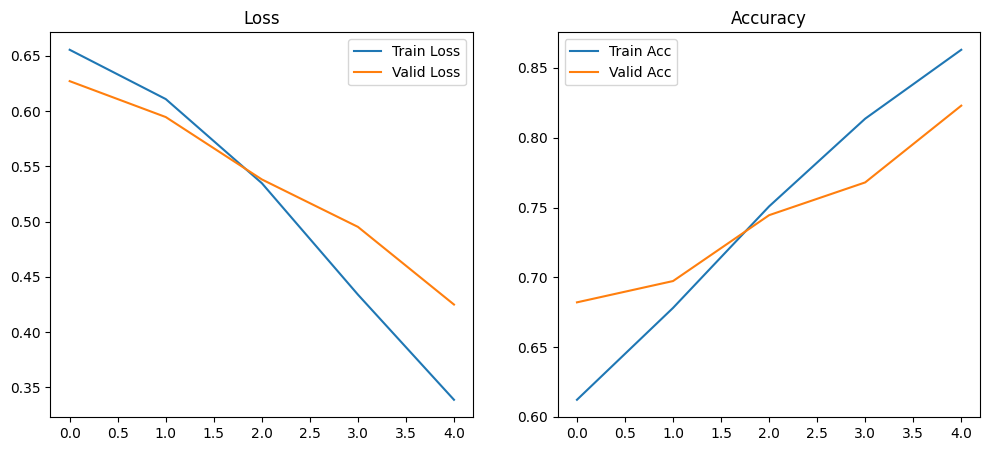

In [10]:
# Training 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Helper Functions
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device) # Move to GPU
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        acc = binary_accuracy(preds, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device) # Move to GPU
            preds = model(x)
            loss = criterion(preds, y)
            acc = binary_accuracy(preds, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)

# Model Setup
model = LSTM(vocab_size=len(word_to_idx), emb_dim=100, hidden_dim=128, num_layers=1, dropout=0.4, bidirectional=True)
model = model.to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.001)    
criterion = nn.BCEWithLogitsLoss()       

# Loop
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
best_valid_loss = float('inf')

start_time = time.time()
for epoch in range(5):
    t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    v_loss, v_acc = evaluate(model, valid_loader, criterion)
    
    train_losses.append(t_loss); valid_losses.append(v_loss)
    train_accs.append(t_acc); valid_accs.append(v_acc)
    
    if v_loss < best_valid_loss:
        best_valid_loss = v_loss
        torch.save(model.state_dict(), 'best-model.pt')
    
    elapsed = time.time() - start_time
    print(f'Epoch: {epoch+1:02} | Time: {elapsed:.0f}s | Train Loss: {t_loss:.3f} | Val Loss: {v_loss:.3f} | Val Acc: {v_acc*100:.2f}%')

# Plotting 

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(valid_accs, label='Valid Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

### Task 10 (5 pts)

Improve your model architecture and training procedure by applying one or more of the following strategies:

* Truncated Backpropagation Through Time
* Better tokenizer
* Pre-trained embeddings
* ....

This exercise is considered successful if **any "sensible" improvement in test accuracy** is achieved, even by applying just one change.

In [11]:
# Check if file exists otherwise download it 
if not os.path.exists('glove.6B.100d.txt'):
    print("Missing GloVe file. Starting download...")
    !wget -q http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip
    print("Download and extraction completed!")
else:
    print("GloVe file already present. Proceeding.")

Missing GloVe file. Starting download...
Download and extraction completed!


Loading GloVe vectors...

Phase 1: Training LSTM (Frozen Embeddings)
Epoch: 01 | Train Loss: 0.675 | Val. Loss: 0.666 | Val. Acc: 60.73%
Epoch: 02 | Train Loss: 0.615 | Val. Loss: 0.560 | Val. Acc: 70.94%
Epoch: 03 | Train Loss: 0.472 | Val. Loss: 0.553 | Val. Acc: 73.95%
Epoch: 04 | Train Loss: 0.396 | Val. Loss: 0.338 | Val. Acc: 84.61%
Epoch: 05 | Train Loss: 0.329 | Val. Loss: 0.323 | Val. Acc: 85.56%
Epoch: 06 | Train Loss: 0.305 | Val. Loss: 0.288 | Val. Acc: 87.02%

 FASE 2: Complete Fine-Tuning  (lower LR)
--> New record saved! (Loss: 0.2758)
Epoch: 01 | Train Loss: 0.264 | Val. Loss: 0.276 | Val. Acc: 88.62%
--> New record saved! (Loss: 0.2695)
Epoch: 02 | Train Loss: 0.247 | Val. Loss: 0.270 | Val. Acc: 88.82%
--> New record saved! (Loss: 0.2654)
Epoch: 03 | Train Loss: 0.233 | Val. Loss: 0.265 | Val. Acc: 89.25%
Epoch: 04 | Train Loss: 0.219 | Val. Loss: 0.277 | Val. Acc: 88.79%
--> New record saved! (Loss: 0.2560)
Epoch: 05 | Train Loss: 0.207 | Val. Loss: 0.256 | Val. Acc:

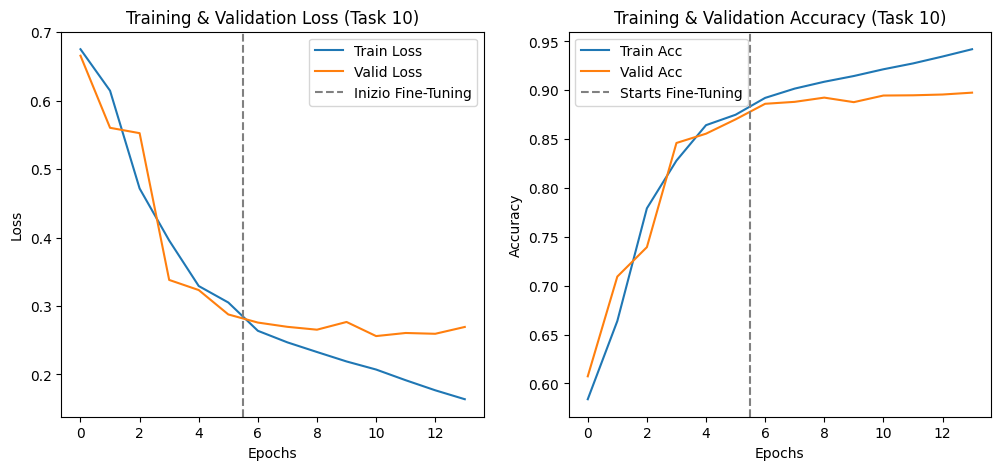

In [ ]:

#Support Function 
def binary_accuracy(preds, y):
    """Calculate accuracy for binary classification."""
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        acc = binary_accuracy(predictions, y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            predictions = model(x)
            loss = criterion(predictions, y)
            acc = binary_accuracy(predictions, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(loader), epoch_acc / len(loader)

# Reloading GloVe Weights
if 'embedding_dict' not in locals():
    print("Loading GloVe vectors...")
    embedding_dict = {}
    with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding_dict[word] = np.asarray(values[1:], dtype='float32')

# Matrix Creation
embedding_matrix = torch.zeros((len(word_to_idx), 100))
for word, idx in word_to_idx.items():
    if word in embedding_dict:
        embedding_matrix[idx] = torch.from_numpy(embedding_dict[word])
    else:
        embedding_matrix[idx] = torch.randn(100)

# Model Initialization
model_best = LSTM(vocab_size=len(word_to_idx), 
                  emb_dim=100, 
                  hidden_dim=256, 
                  num_layers=2, 
                  dropout=0.5, 
                  bidirectional=True).to(device)

model_best.embedding.weight.data.copy_(embedding_matrix)

# Lists to save results from both phases
all_train_losses = []
all_valid_losses = []
all_train_accs = []
all_valid_accs = []


# PHASE 1: TRAINING WITH FROZEN EMBEDDINGS
print("\nPhase 1: Training LSTM (Frozen Embeddings)")
model_best.embedding.weight.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_best.parameters()), 
                       lr=0.001, 
                       weight_decay=1e-5)

best_valid_loss = float('inf')
criterion = nn.BCEWithLogitsLoss()

for epoch in range(6): 
    train_loss, train_acc = train_one_epoch(model_best, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_best, valid_loader, criterion)
    
    # Saving metrics
    all_train_losses.append(train_loss)
    all_valid_losses.append(valid_loss)
    all_train_accs.append(train_acc)
    all_valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_best.state_dict(), 'best_model_phase1.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')


# Phase 2: FINE-TUNING (UnFrozen)

print("\n Phase 2: Complete Fine-Tuning  (lower LR)")
model_best.load_state_dict(torch.load('best_model_phase1.pt'))
model_best.embedding.weight.requires_grad = True

optimizer = optim.Adam(model_best.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_valid_loss_final = float('inf')

for epoch in range(8):
    train_loss, train_acc = train_one_epoch(model_best, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_best, valid_loader, criterion)
    
    # Saving metrics
    all_train_losses.append(train_loss)
    all_valid_losses.append(valid_loss)
    all_train_accs.append(train_acc)
    all_valid_accs.append(valid_acc)
    
    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss_final:
        best_valid_loss_final = valid_loss
        torch.save(model_best.state_dict(), 'best_model_final.pt')
        print(f"--> New record saved! (Loss: {valid_loss:.4f})")
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

# Final Evaluation 
model_best.load_state_dict(torch.load('best_model_final.pt'))
test_loss, test_acc = evaluate(model_best, test_loader, criterion)
print(f'\nTest Final Accuracy: {test_acc*100:.2f}%')

# Plotting 
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(all_train_losses, label='Train Loss')
plt.plot(all_valid_losses, label='Valid Loss')
plt.axvline(x=5.5, color='gray', linestyle='--', label='Inizio Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(all_train_accs, label='Train Acc')
plt.plot(all_valid_accs, label='Valid Acc')
plt.axvline(x=5.5, color='gray', linestyle='--', label='Starts Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

### Task 11 (5 pts)

Use one of your trained models to perform sentiment analysis on the following reviews. Be prepared to explain any issues you encountered and how you addressed them.

In [13]:
# Prediction Function for Single Sentence
def predict_sentiment(model, text, word_to_idx):
    """
   Takes a raw string, processes it, and returns the probability of it being positive.
    """
    model.eval() # Set the model to evaluation mode (turns off Dropout)
    
    # 1. Pre-processing Pipeline  (same as training)
    tokens = tokenize(text)
    
    # 2. Word to index conversion
    unk_idx = word_to_idx['<UNK>'] #Use the <UNK> index for previously unseen words
    indices = [word_to_idx.get(t, unk_idx) for t in tokens]
    
    # 3. Creation of the tensor 
    tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    
    # 4. Inference
    with torch.no_grad():
        logits = model(tensor) 
        probability = torch.sigmoid(logits).item() 
        
    return probability

# Test 
iron_man_review = """
Iron Man isn't just a superhero movie. It's the spark that ignited the entire Marvel Cinematic Universe. With Robert Downey Jr.'s career-defining performance, razor-sharp writing, and a perfect blend of heart, humor, and high-tech spectacle, this film redefined what a comic book movie could be.

Even after more than a decade, Iron Man remains one of the most re-watchable, charming, and influential superhero origin stories ever made.

🎬 Overview

Iron Man introduces Tony Stark (Robert Downey Jr.), a brilliant but arrogant billionaire weapons manufacturer. When he's captured by terrorists in Afghanistan and forced to build a missile, Tony instead constructs a powered suit of armor to escape.

Haunted by the destruction caused by his weapons, Stark returns home determined to reinvent himself. Not as a war profiteer, but as Iron Man, a hero powered by his mind, conscience, and an arc reactor in his chest.

Along the way, he faces betrayal from within his company, moral dilemmas, and a growing awareness of what true responsibility means.

✅ What Worked

1. Robert Downey Jr.: Perfect casting. His charisma, wit, and emotional depth made Tony Stark unforgettable.

2. Grounded realism: The technology feels just believable enough to make Iron Man's world plausible.

3. Sharp writing and humor: Smart, fast-paced dialogue that balances action with personality.

4. Emotional arc: Tony's transformation from egocentric arms dealer to self-aware hero feels authentic.

5. Cinematography & effects: The first suit build and flight sequences are still jaw-dropping.

6. Gwyneth Paltrow & Jeff Bridges: Excellent supporting cast. Pepper Potts' loyalty and Obadiah Stane's menace both shine.

7. The ending line: That bold, improvised moment "I am Iron Man." changed superhero cinema forever.

❌ What Didn't Work

1. Final battle pacing: The showdown between Iron Man and Iron Monger feels slightly rushed.

2. Limited female representation: Pepper is great, but she's one of very few women in a male-dominated cast.

3. Predictable villain motivation: Stane's greed is a bit by-the-numbers.

But honestly. These are small cracks in an otherwise near-perfect armor.

💬 Favorite Quotes / Moments

"I am Iron Man." - Tony Stark "Sometimes you've gotta run before you can walk.\" - Tony Stark "My turn." - Tony, before launching a missile at a tank "Is it better to be feared or respected? I say, is it too much to ask for both?" - Tony Stark Tony's first cave suit escape: gritty, powerful, and unforgettable.

The Mark II flight test: pure cinematic joy as Tony takes to the skies.

Pepper replacing Tony's arc reactor: both funny and intimate.

The press conference ending: Tony discarding the superhero secrecy trope in one iconic line.

The post-credit scene: Nick Fury's appearance teasing the Avengers Initiative (and the MCU as we know it).

💡 Fun Facts

1. Robert Downey Jr. Was not Marvel's first choice but his audition blew everyone away.

2. Much of the film's dialogue was improvised, including "I am Iron Man."

3. The movie was Marvel Studios' first independent production, made before Disney bought them.

4. Jon Favreau insisted on using practical effects for the suits wherever possible.

5. The success of Iron Man directly led to the creation of the MCU, which has since become the highest-grossing franchise in film history.

6. Tony Stark's mansion was CGI. It doesn't actually exist!

🎥 If You Liked This, You Might Also Enjoy

1. The Dark Knight (2008): Another intelligent and grounded superhero reboot.

2. Iron Man 2 (2010): The next chapter in Tony Stark's evolution.

3. Doctor Strange (2016): A spiritual successor exploring genius and redemption.

4. Captain America: The First Avenger (2011): Marvel's other essential origin story.

5. The Social Network (2010): Not a superhero movie, but a study of brilliance and ego that echoes Stark's early character.

Final Thoughts

Iron Man remains the gold standard for superhero origin stories. A perfect fusion of innovation, attitude, and emotion. It's not just about a man in a suit; it's about a man who learns to use his mind and heart for something greater.

Final Verdict: (9.5/10). "The birth of Iron Man was also the birth of a cinematic universe and it still flies higher than ever."
"""

# Loading the weights of the best model
try:
    model_best.load_state_dict(torch.load('best_model_final.pt'))
    print("Model 'best_model_final.pt' loaded successfully.")
except FileNotFoundError:
    print("Model file not found.")

# Make the prediction 
probability = predict_sentiment(model_best, iron_man_review, word_to_idx)

print("-" * 30)
print(f"Probability of Positivity:: {probability:.4f}")
print(f"Estimated Sentiment {'Positive' if probability > 0.5 else 'Negative'}")
print("-" * 30)

Model 'best_model_final.pt' loaded successfully.
------------------------------
Probability of Positivity:: 0.9907
Estimated Sentiment Positive
------------------------------


## Questions

During the presentation, we may ask questions to ensure you have understood the core concepts of the course. Examples include:

1.	What is the hidden state in a recurrent neural network (RNN), and what role does it play during sequence processing?
2.	Why do we need padding when working with batches of variable-length sequences? How is padding typically handled in practice?
3.	What is a stacked RNN, and why might stacking multiple recurrent layers improve performance?
4.	What is a bidirectional RNN, and in which scenarios does it provide an advantage?
5.	What is the exploding gradient problem in recurrent networks?
6.	What is the vanishing gradient problem, and why is it particularly severe in RNNs?
7.	What is gradient clipping, and why is it commonly applied when training RNNs?
8.	How do different activation functions influence vanishing or exploding gradients in deep or recurrent networks?
9.	What is truncated backpropagation through time, and why is it used when training RNNs?
10.	What is one-hot encoding for representing words in a vocabulary? What are its limitations?
11.	What does `nn.Embedding` do, and why is it preferred over one-hot encoding?
12.	What are gating mechanisms in recurrent architectures (e.g., LSTM/GRU), and why are they important?
	13.	How do LSTM gates help mitigate the vanishing gradient problem?